In [22]:
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [3]:
traindf=mnist_dataset['train']
testdf=mnist_dataset['test']


In [5]:
trainX=[]
trainY=[]
testX=[]
testY=[]
for image, label in traindf:
    trainX.append(image.numpy().squeeze()) 
    trainY.append(label.numpy())

for image, label in testdf:
    testX.append(image.numpy().squeeze()) 
    testY.append(label.numpy())

trainX=np.array(trainX)
trainY=np.array(trainY)
testX=np.array(testX)
testY=np.array(testY)


print("Training images shape:",trainX.shape)
print("Training labels shape:", trainY.shape)
print("Test images shape:", testX.shape)
print("Test labels shape:", testY.shape)


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


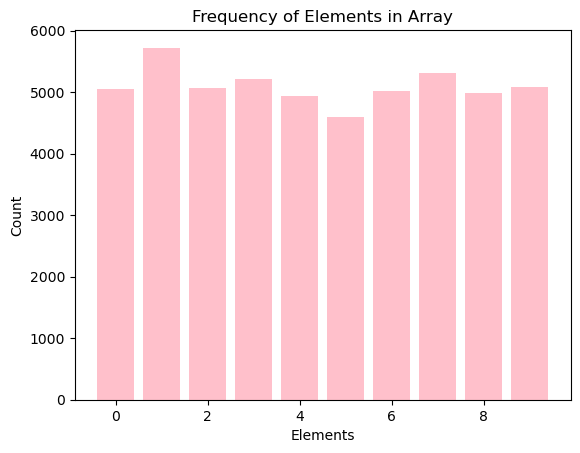

In [ ]:
unt,untc=np.unique(trainY,return_counts=True)
plt.bar(unt, untc, color='pink')
plt.xlabel('Elements')
plt.ylabel('Count')
plt.title('Frequency of Elements in train data')
plt.show()


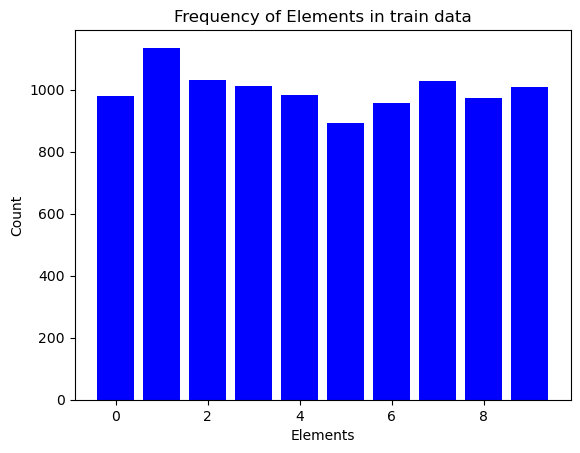

In [28]:
unt,untc=np.unique(testY,return_counts=True)
plt.bar(unt, untc, color='blue')
plt.xlabel('Elements')
plt.ylabel('Count')
plt.title('Frequency of Elements in train data')
plt.show()

In [ ]:
trainX = trainX.astype('float32') / 255.0  # Scale to [0, 1]
testX = testX.astype('float32') / 255.0
trainX = np.expand_dims(trainX, axis=-1)  # Adds channel dimension (e.g., for grayscale)
testX = np.expand_dims(testX, axis=-1)
print("X_train shape:", trainX.shape)  # e.g., (60000, 28, 28, 1)
print("y_train shape:", trainY.shape)  # e.g., (60000,) or (60000, 10)

In [10]:
valXn=int(trainX.shape[0]*0.15)
valX=trainX[trainX.shape[0]-valXn:]
valY=trainY[trainY.shape[0]-valXn:]
trainX=trainX[0:trainX.shape[0]-valXn]
trainY=trainY[0:trainY.shape[0]-valXn]

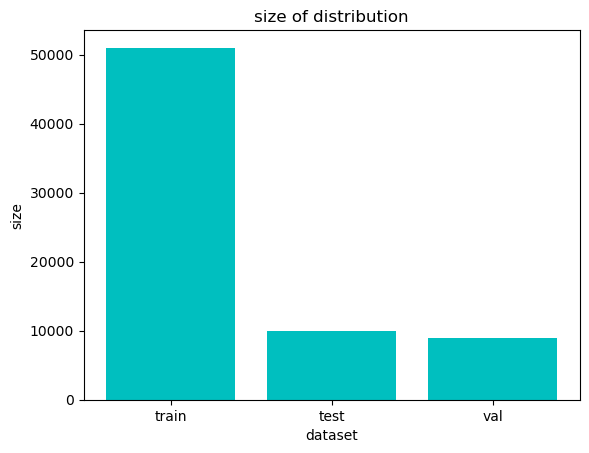

In [30]:
names=["train","test","val"]
size=[trainX.shape[0],testX.shape[0],valX.shape[0]]
plt.bar(names, size, color='c')
plt.xlabel('dataset')
plt.ylabel('size')
plt.title('size of distribution')
plt.show()

In [ ]:
print(testlabel[20])
import matplotlib.pyplot as plt
plt.imshow(testimage[20], cmap='Blues')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extract one batch (or example) from the dataset
for image, label in traindf.take(1):
    # Convert TensorFlow tensors to numpy arrays
    image_np = image.numpy().squeeze()  # Shape: (28, 28, 1) → (28, 28)
    label_np = label.numpy()

    # Plot the image
    plt.imshow(image_np, cmap='Blues')
    plt.title(f"Label: {label_np}")
    plt.axis('off')
    plt.show()

In [11]:
import numpy as np
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def cross_entropy_loss(y_pred, y_true):
    return -np.mean(y_true * np.log(y_pred + 1e-8))

In [12]:
# when creating a layer think about how the array or layer interacts instead of each individual node
class Layer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.zeros((1, output_dim))#np.zeros creates an array of given length filled with zero
    
    def forward(self,input):
        self.input=input
        self.z=(np.dot(input,self.weights)+self.bias)
        self.z=relu(self.z)
        return self.z
    
    def backward(self, grad, learning_rate):
        delta = grad * relu_derivative(self.z)
        dW = np.dot(self.input.T, delta)
        db = np.sum(delta, axis=0, keepdims=True)
        dW = np.clip(dW, -1, 1)
        db = np.clip(db, -1, 1)
        self.weights -= learning_rate * dW
        self.bias -= learning_rate * db
        grad_prev = np.dot(delta, self.weights.T)
        return grad_prev
    

class Outputlayer(Layer):
    def forward(self, input):
        self.input=input
        self.z=(np.dot(input,self.weights)+self.bias)
        self.z=softmax(self.z)
        return self.z
    
    def backward(self, grad, learning_rate):
        dW = np.dot(self.input.T, grad)
        db = np.sum(grad, axis=0, keepdims=True)
        dW = np.clip(dW, -1, 1)
        db = np.clip(db, -1, 1)
        self.weights -= learning_rate * dW
        self.bias -= learning_rate * db
        return np.dot(grad, self.weights.T)



In [13]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size=1):
        self.layers = []
        sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)):
            self.layers.append(Layer(sizes[i], sizes[i+1]))
        self.layers.append(Outputlayer(hidden_sizes[-1], output_size))
    
    def forward(self, X):
        a = X
        for layer in self.layers:
            a = layer.forward(a)
        return a
    
    def backward(self, X, y, learning_rate):
        y_pred = self.forward(X)
        m = X.shape[0]
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        grad = (y_pred - y) / m
        for layer in reversed(self.layers):
            grad = layer.backward(grad, learning_rate)

In [14]:
def train_model( input_size, hidden_units, epochs=1000, lr=0.001):
    X_train, y_train=testX,trainY
    X_val, y_val = valX,valY
    model = NeuralNetwork(input_size=input_size, hidden_sizes=hidden_units, output_size=10)
    for epoch in range(epochs):
        y_pred = model.forward(X_train)
        loss = cross_entropy_loss(y_pred,y_train,)
        model.backward(X_train, y_train, lr)
        val_pred = model.forward(X_val)
        val_loss = cross_entropy_loss(val_pred,y_val)
        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f}")
    return model
    

In [18]:
def evaluate_model(model):
    X_test, y_test = testX,testY
    y_pred = model.forward(X_test)
    loss = cross_entropy_loss(y_pred,y_test)

In [19]:
INPUT_SIZE=1
HIDDEN_UNITS=[50,1]

In [20]:
model = train_model(
input_size=INPUT_SIZE,
hidden_units=HIDDEN_UNITS)
evaluate_model(model)

ValueError: operands could not be broadcast together with shapes (51000,) (10000,28,28,10) 